In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load data
df = pd.read_csv("airport_traffic_2024.csv")
df['FLT_DATE'] = pd.to_datetime(df['FLT_DATE'], format='%d-%m-%y')

# Fill missing IFR values with 0
ifr_cols = ['FLT_DEP_IFR_2', 'FLT_ARR_IFR_2', 'FLT_TOT_IFR_2']
df[ifr_cols] = df[ifr_cols].fillna(0)

# Sort by airport and date
df = df.sort_values(by=['APT_ICAO', 'FLT_DATE']).reset_index(drop=True)

# ======================
# 📅 Time-based Features
# ======================
df['day'] = df['FLT_DATE'].dt.day
df['month'] = df['FLT_DATE'].dt.month
df['weekday'] = df['FLT_DATE'].dt.weekday
df['dayofyear'] = df['FLT_DATE'].dt.dayofyear
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)
df['is_peak_season'] = df['month'].isin([6, 7, 8, 12]).astype(int)

# ====================
# 🔁 Lag & Rolling Features
# ====================
group = df.groupby('APT_ICAO')
df['lag_1'] = group['FLT_TOT_1'].shift(1)
df['lag_2'] = group['FLT_TOT_1'].shift(2)
df['lag_7'] = group['FLT_TOT_1'].shift(7)
df['roll_mean_3'] = group['FLT_TOT_1'].transform(lambda x: x.shift(1).rolling(3).mean())
df['roll_mean_7'] = group['FLT_TOT_1'].transform(lambda x: x.shift(1).rolling(7).mean())

# Drop rows with NaNs from lagging
df.dropna(inplace=True)

# ====================
# 🔍 Define Features and Target
# ====================
target_col = 'FLT_TOT_1'
input_cols = [
    'FLT_DEP_1', 'FLT_ARR_1',
    'FLT_DEP_IFR_2', 'FLT_ARR_IFR_2', 'FLT_TOT_IFR_2',
    'day', 'month', 'weekday', 'dayofyear', 'is_weekend', 'is_peak_season',
    'lag_1', 'lag_2', 'lag_7', 'roll_mean_3', 'roll_mean_7'
]

# ====================
# ⚖️ Scaling
# ====================
# Scale inputs
X_scaler = StandardScaler()
df[input_cols] = X_scaler.fit_transform(df[input_cols])

# Scale target separately
y_scaler = StandardScaler()
df[[target_col]] = y_scaler.fit_transform(df[[target_col]])

# ✅ Final output
X = df[input_cols]
y = df[target_col]

print("✅ Preprocessing complete. Features and target are ready.")


✅ Preprocessing complete. Features and target are ready.


🔍 Checking missing values...
YEAR              0
MONTH_NUM         0
MONTH_MON         0
FLT_DATE          0
APT_ICAO          0
APT_NAME          0
STATE_NAME        0
FLT_DEP_1         0
FLT_ARR_1         0
FLT_TOT_1         0
FLT_DEP_IFR_2     0
FLT_ARR_IFR_2     0
FLT_TOT_IFR_2     0
day               0
month             0
weekday           0
dayofyear         0
is_weekend        0
is_peak_season    0
lag_1             0
lag_2             0
lag_7             0
roll_mean_3       0
roll_mean_7       0
dtype: int64

📊 Correlation matrix:

📈 Correlation with FLT_TOT_1:
FLT_TOT_1         1.000000
FLT_ARR_1         0.999883
FLT_DEP_1         0.999883
lag_7             0.996429
roll_mean_7       0.995219
roll_mean_3       0.993584
lag_1             0.992314
lag_2             0.989560
FLT_TOT_IFR_2     0.937144
FLT_DEP_IFR_2     0.937062
FLT_ARR_IFR_2     0.937025
is_peak_season    0.033438
MONTH_NUM         0.023473
month             0.023473
dayofyear         0.023088
weekday           0

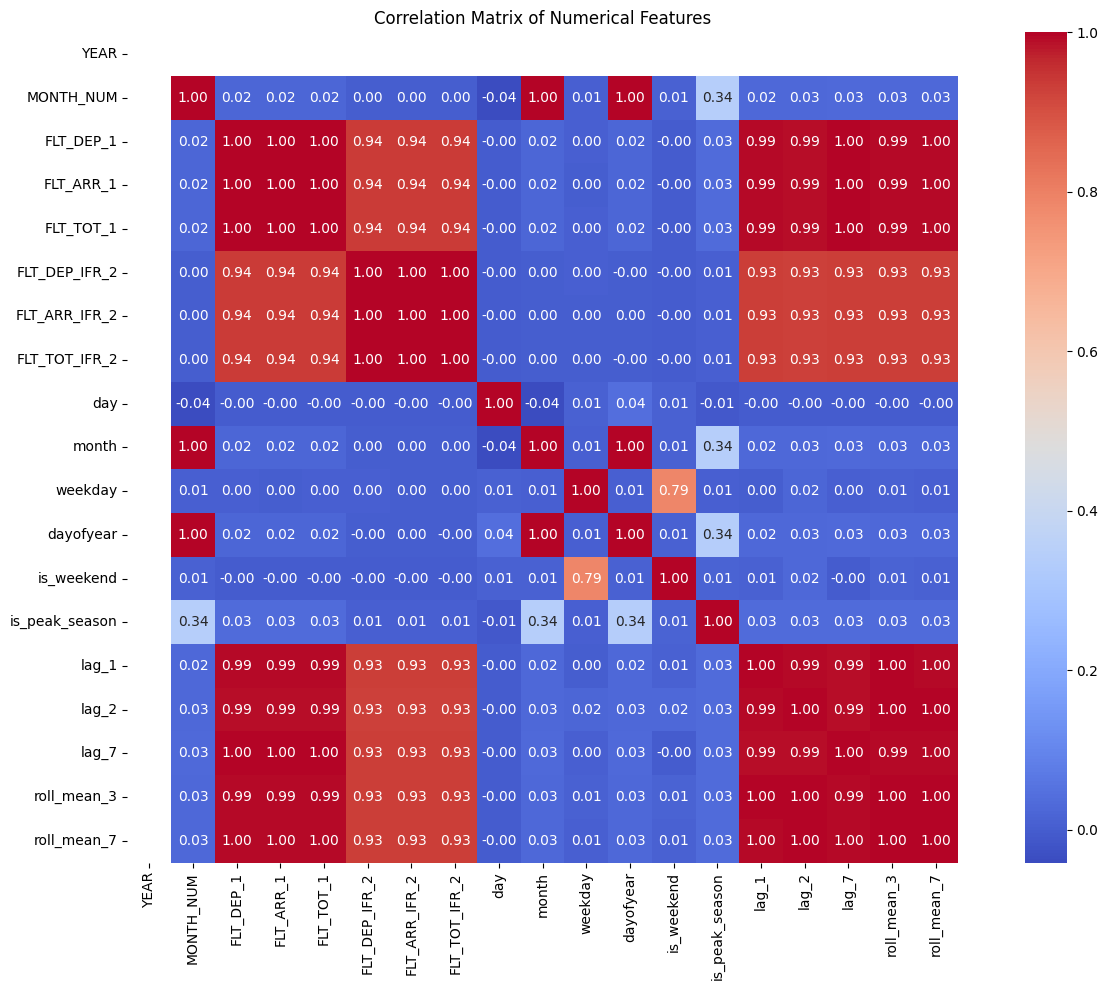

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Check for missing values
print("🔍 Checking missing values...")
missing_values = df.isnull().sum()
print(missing_values)

# Step 2: Correlation matrix for numerical features
print("\n📊 Correlation matrix:")
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = df[numerical_cols].corr()

# Step 3: Correlation with target variable FLT_TOT_1
print("\n📈 Correlation with FLT_TOT_1:")
print(correlation_matrix['FLT_TOT_1'].sort_values(ascending=False))

# Step 4: Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()
plt.show()


In [17]:
# ⚠️ Ensure data is sorted by date BEFORE splitting
df = df.sort_values('FLT_DATE').reset_index(drop=True)

# Determine split indices
n = len(df)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

# Apply split
X_train = X.iloc[:train_end]
y_train = y.iloc[:train_end]

X_val = X.iloc[train_end:val_end]
y_val = y.iloc[train_end:val_end]

X_test = X.iloc[val_end:]
y_test = y.iloc[val_end:]

print(f"✅ Data split complete:")
print(f"- Train: {X_train.shape[0]} samples")
print(f"- Validation: {X_val.shape[0]} samples")
print(f"- Test: {X_test.shape[0]} samples")


✅ Data split complete:
- Train: 67465 samples
- Validation: 22489 samples
- Test: 22489 samples


In [18]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='mse',
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)


In [19]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.9530 - mean_absolute_error: 0.6896 - val_loss: 0.1130 - val_mean_absolute_error: 0.3031
Epoch 2/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2005 - mean_absolute_error: 0.3241 - val_loss: 0.0389 - val_mean_absolute_error: 0.1641
Epoch 3/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1227 - mean_absolute_error: 0.2476 - val_loss: 0.0266 - val_mean_absolute_error: 0.1322
Epoch 4/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0992 - mean_absolute_error: 0.2146 - val_loss: 0.0220 - val_mean_absolute_error: 0.1094
Epoch 5/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0777 - mean_absolute_error: 0.1863 - val_loss: 0.0164 - val_mean_absolute_error: 0.0949
Epoch 6/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0699 - mean_absolute_error: 0.1728 - val_loss: 0.0237 - val_mean_absolute_error: 0.0947
Epoch 7/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0641 - mean_absolute_error: 0.1

703/703 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step
✅ Final Evaluation on Test Set:
RMSE: 0.15
MAE: 0.07
R² Score: 0.9817


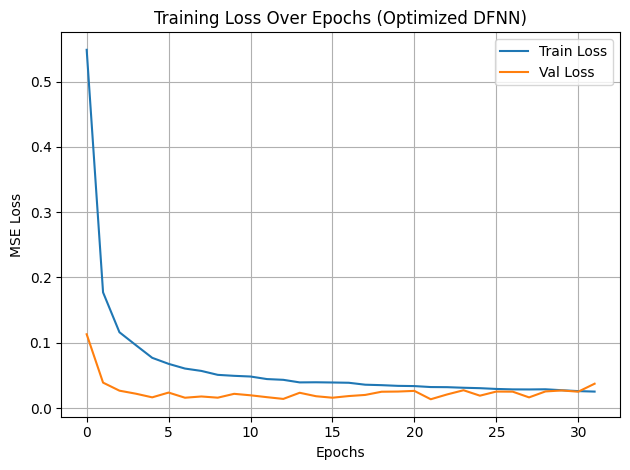

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Predict on test set
y_pred = model.predict(X_test).flatten()

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("✅ Final Evaluation on Test Set:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# Plot training loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training Loss Over Epochs (Optimized DFNN)')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


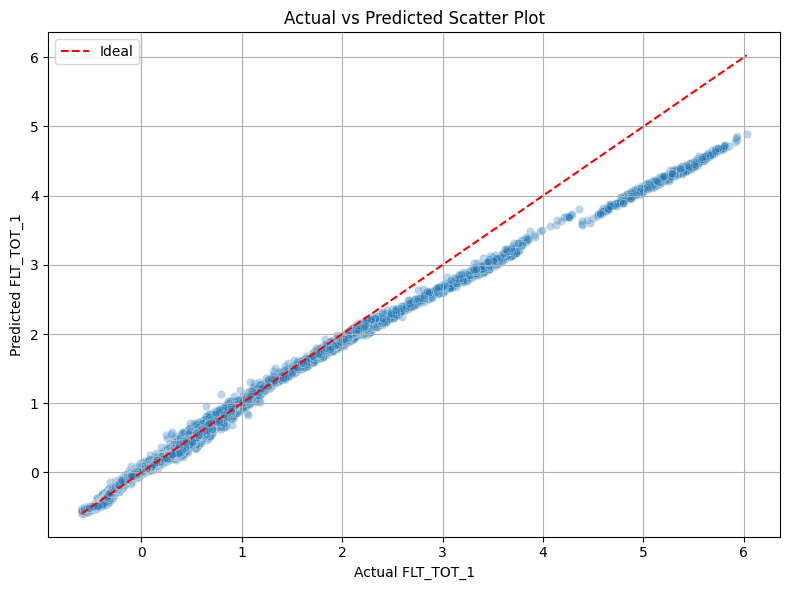

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a DataFrame
results_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
})

# Plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df, x='Actual', y='Predicted', alpha=0.3)
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()],
         [results_df['Actual'].min(), results_df['Actual'].max()],
         color='red', linestyle='--', label='Ideal')
plt.title('Actual vs Predicted Scatter Plot')
plt.xlabel('Actual FLT_TOT_1')
plt.ylabel('Predicted FLT_TOT_1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
# ✅ Define Weighted MSE Loss Function
import tensorflow as tf

# Define weighted loss (same as before)
def weighted_mse(y_true, y_pred):
    weight = tf.math.square(y_true)
    return tf.reduce_mean(weight * tf.square(y_pred - y_true))

# Build smaller, more regularized model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(48, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile with lower learning rate and weighted loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss=weighted_mse,
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

# Retrain the model
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history_weighted_tuned = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)



Epoch 1/100
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 13.2217 - mean_absolute_error: 1.2551 - val_loss: 0.1574 - val_mean_absolute_error: 0.3787
Epoch 2/100
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 943us/step - loss: 2.1260 - mean_absolute_error: 0.8578 - val_loss: 0.1213 - val_mean_absolute_error: 0.3363
Epoch 3/100
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 935us/step - loss: 1.6746 - mean_absolute_error: 0.7259 - val_loss: 0.1967 - val_mean_absolute_error: 0.4086
Epoch 4/100
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 971us/step - loss: 1.2807 - mean_absolute_error: 0.6818 - val_loss: 0.2172 - val_mean_absolute_error: 0.4973
Epoch 5/100
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 936us/step - loss: 1.2053 - mean_absolute_error: 0.6699 - val_loss: 0.2113 - val_mean_absolute_error: 0.5421
Epoch 6/100
528/528 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 1.0885 - mean_absolute_error: 0.6524 - val_loss: 0.2350 - val_mean_absolute_error: 0.5395
Epoch 7/100
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 930us/step - loss: 0.9966 - mean_absolu

703/703 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step
✅ Evaluation of Tuned Weighted MSE Model:
RMSE: 0.5653
MAE: 0.4466
R² Score: 0.7293


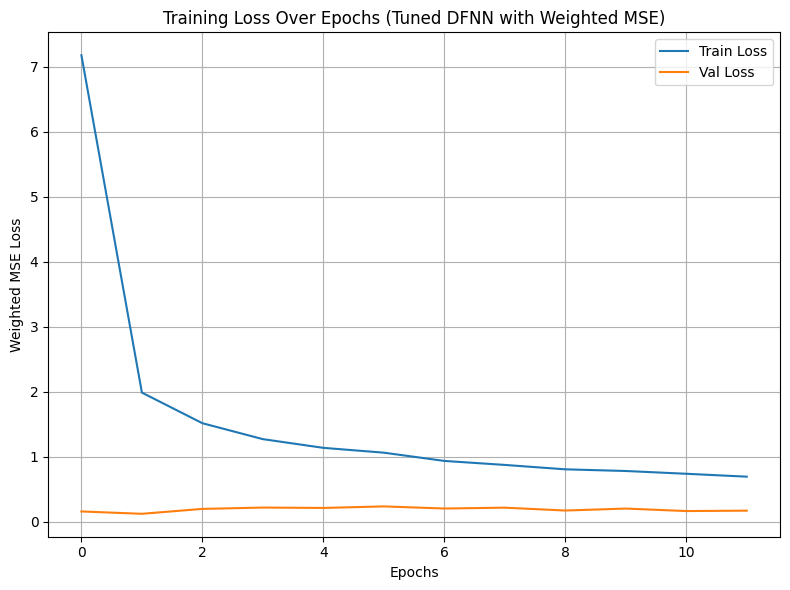

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 🔍 Predict on test set
y_pred_weighted_tuned = model.predict(X_test).flatten()

# 📊 Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred_weighted_tuned))
mae = mean_absolute_error(y_test, y_pred_weighted_tuned)
r2 = r2_score(y_test, y_pred_weighted_tuned)

print("✅ Evaluation of Tuned Weighted MSE Model:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# 📈 Training Loss Plot
plt.figure(figsize=(8, 6))
plt.plot(history_weighted_tuned.history['loss'], label='Train Loss')
plt.plot(history_weighted_tuned.history['val_loss'], label='Val Loss')
plt.title('Training Loss Over Epochs (Tuned DFNN with Weighted MSE)')
plt.xlabel('Epochs')
plt.ylabel('Weighted MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


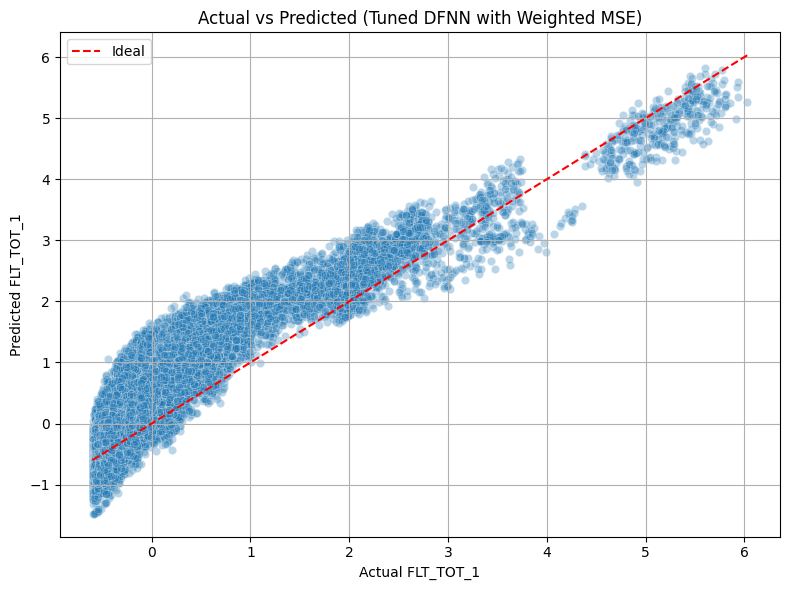

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create comparison DataFrame
results_df_tuned = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred_weighted_tuned
})

# Scatter Plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df_tuned, x='Actual', y='Predicted', alpha=0.3)
plt.plot([results_df_tuned['Actual'].min(), results_df_tuned['Actual'].max()],
         [results_df_tuned['Actual'].min(), results_df_tuned['Actual'].max()],
         color='red', linestyle='--', label='Ideal')
plt.title('Actual vs Predicted (Tuned DFNN with Weighted MSE)')
plt.xlabel('Actual FLT_TOT_1')
plt.ylabel('Predicted FLT_TOT_1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

# 🎯 Custom Weighted MSE Loss
def weighted_mse(y_true, y_pred):
    weight = tf.math.square(y_true)
    return tf.reduce_mean(weight * tf.square(y_pred - y_true))

# 🏗️ Model Builder Function
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(X_train.shape[1],)))

    for i in range(hp.Int('num_layers', 2, 4)):
        model.add(keras.layers.Dense(
            units=hp.Choice(f'units_{i}', [32, 64, 128]),
            activation='relu'))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dropout(
            rate=hp.Choice(f'dropout_{i}', [0.2, 0.3, 0.4])))

    model.add(keras.layers.Dense(1))

    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [1e-3, 3e-4, 1e-4])
        ),
        loss=weighted_mse,
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )

    return model

# 🧽 Clear previous tuner and reinitialize
import shutil
shutil.rmtree('kt_dir', ignore_errors=True)

# 🔎 Initialize Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='kt_dir',
    project_name='dnn_weighted_mse_tuning'
)

# 🛑 Early Stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# 🚀 Run the fresh search
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)


Trial 10 Complete [00h 00m 32s]
val_loss: 0.023590993136167526

Best val_loss So Far: 0.019676560536026955
Total elapsed time: 00h 04m 57s


In [29]:
# ✅ Retrieve best model from the tuner
best_model = tuner.get_best_models(num_models=1)[0]

# 💾 Save model in the recommended format (.keras)
best_model.save("best_model_tuned.keras")

print("✅ Best model saved as: best_model_tuned.keras")


✅ Best model saved as: best_model_tuned.keras


c:\Users\Ong\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 🔍 Predict using best model
y_pred_scaled = best_model.predict(X_test).flatten()

# 📊 Evaluate on normalized scale
rmse = np.sqrt(mean_squared_error(y_test, y_pred_scaled))
mae = mean_absolute_error(y_test, y_pred_scaled)
r2 = r2_score(y_test, y_pred_scaled)

print("📌 Evaluation on Normalized Test Set:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")


703/703 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step
📌 Evaluation on Normalized Test Set:
RMSE: 0.1634
MAE: 0.1264
R² Score: 0.9774


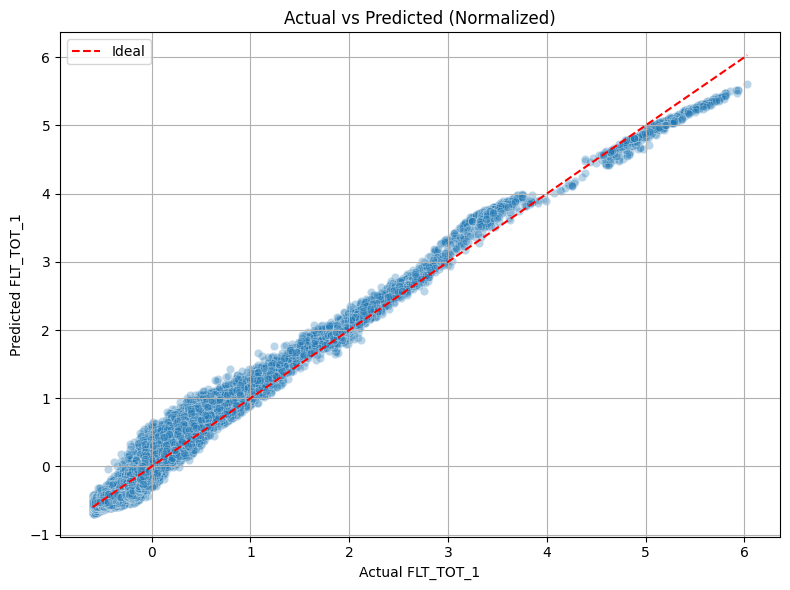

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 📊 Create comparison DataFrame
results_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred_scaled
})

# 📈 Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df, x='Actual', y='Predicted', alpha=0.3)
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()],
         [results_df['Actual'].min(), results_df['Actual'].max()],
         color='red', linestyle='--', label='Ideal')
plt.title('Actual vs Predicted (Normalized)')
plt.xlabel('Actual FLT_TOT_1')
plt.ylabel('Predicted FLT_TOT_1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# 🔍 Get best hyperparameters from tuner
best_hps = tuner.get_best_hyperparameters(1)[0]

# 🧠 Rebuild the model manually using best hyperparameters
model_retrained = keras.Sequential()
model_retrained.add(keras.layers.Input(shape=(X_train.shape[1],)))

for i in range(best_hps.get('num_layers')):
    model_retrained.add(keras.layers.Dense(
        best_hps.get(f'units_{i}'), activation='relu'))
    model_retrained.add(keras.layers.BatchNormalization())
    model_retrained.add(keras.layers.Dropout(best_hps.get(f'dropout_{i}')))

model_retrained.add(keras.layers.Dense(1))

# 🎯 Compile with same custom loss
model_retrained.compile(
    optimizer=keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate')),
    loss=weighted_mse,
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

# 🛑 Early stopping for safe training
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

# 🚀 Train and track history
history = model_retrained.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
528/528 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.5812 - mean_absolute_error: 0.9979 - val_loss: 0.7830 - val_mean_absolute_error: 0.3554
Epoch 2/100
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.9986 - mean_absolute_error: 0.6713 - val_loss: 0.6075 - val_mean_absolute_error: 0.2083
Epoch 3/100
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7423 - mean_absolute_error: 0.5682 - val_loss: 0.3199 - val_mean_absolute_error: 0.1737
Epoch 4/100
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5844 - mean_absolute_error: 0.5119 - val_loss: 0.2879 - val_mean_absolute_error: 0.1437
Epoch 5/100
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5160 - mean_absolute_error: 0.4723 - val_loss: 0.2990 - val_mean_absolute_error: 0.1291
Epoch 6/100
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4677 - mean_absolute_error: 0.4443 - val_loss: 0.4556 - val_mean_absolute_error: 0.1345
Epoch 7/100
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4503 - mean_absolute_error: 0.4

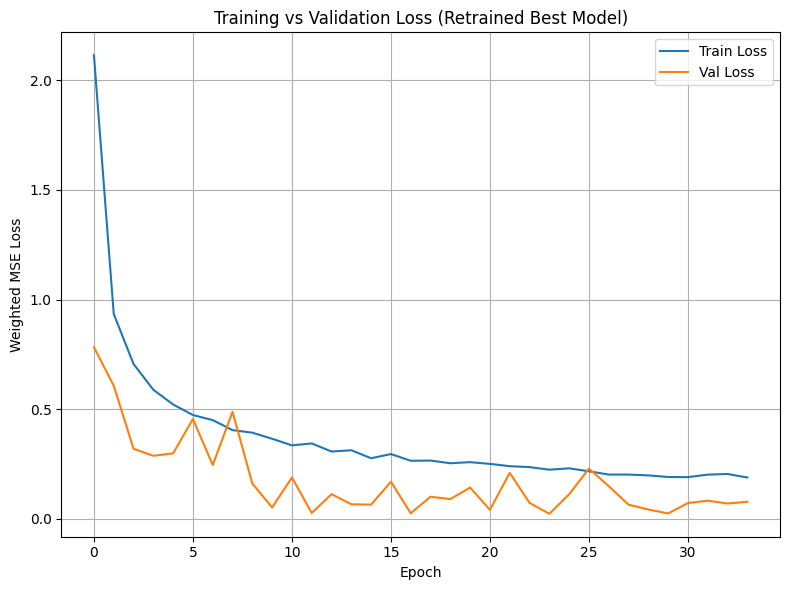

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss (Retrained Best Model)')
plt.xlabel('Epoch')
plt.ylabel('Weighted MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [36]:
# 🎯 Improved Weighted MSE Loss
def weighted_mse(y_true, y_pred):
    weight = tf.math.pow(tf.abs(y_true), 2.0)  # stronger emphasis on large true values
    return tf.reduce_mean(weight * tf.square(y_pred - y_true))

# 🧠 Rebuild model using best hyperparameters
model_improved = keras.Sequential()
model_improved.add(keras.layers.Input(shape=(X_train.shape[1],)))

for i in range(best_hps.get('num_layers')):
    model_improved.add(keras.layers.Dense(best_hps.get(f'units_{i}'), activation='relu'))
    model_improved.add(keras.layers.BatchNormalization())
    model_improved.add(keras.layers.Dropout(best_hps.get(f'dropout_{i}')))

model_improved.add(keras.layers.Dense(1))

# ⚙️ Compile
model_improved.compile(
    optimizer=keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate')),
    loss=weighted_mse,
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

# 🛑 Early stopping (more patience)
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# 🚀 Train
history_improved = model_improved.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/150
528/528 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.5005 - mean_absolute_error: 0.8925 - val_loss: 0.5867 - val_mean_absolute_error: 0.2578
Epoch 2/150
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.9850 - mean_absolute_error: 0.6399 - val_loss: 0.2323 - val_mean_absolute_error: 0.1578
Epoch 3/150
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7367 - mean_absolute_error: 0.5499 - val_loss: 0.4648 - val_mean_absolute_error: 0.1474
Epoch 4/150
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6458 - mean_absolute_error: 0.4980 - val_loss: 0.3262 - val_mean_absolute_error: 0.1461
Epoch 5/150
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5447 - mean_absolute_error: 0.4674 - val_loss: 0.2190 - val_mean_absolute_error: 0.1344
Epoch 6/150
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5056 - mean_absolute_error: 0.4427 - val_loss: 0.1017 - val_mean_absolute_error: 0.1343
Epoch 7/150
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4244 - mean_absolute_error: 0.4

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predict
y_pred_improved = model_improved.predict(X_test).flatten()

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred_improved))
mae = mean_absolute_error(y_test, y_pred_improved)
r2 = r2_score(y_test, y_pred_improved)

print("📌 Evaluation (Improved Weighted MSE):")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")


703/703 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step
📌 Evaluation (Improved Weighted MSE):
RMSE: 0.1522
MAE: 0.1151
R² Score: 0.9804


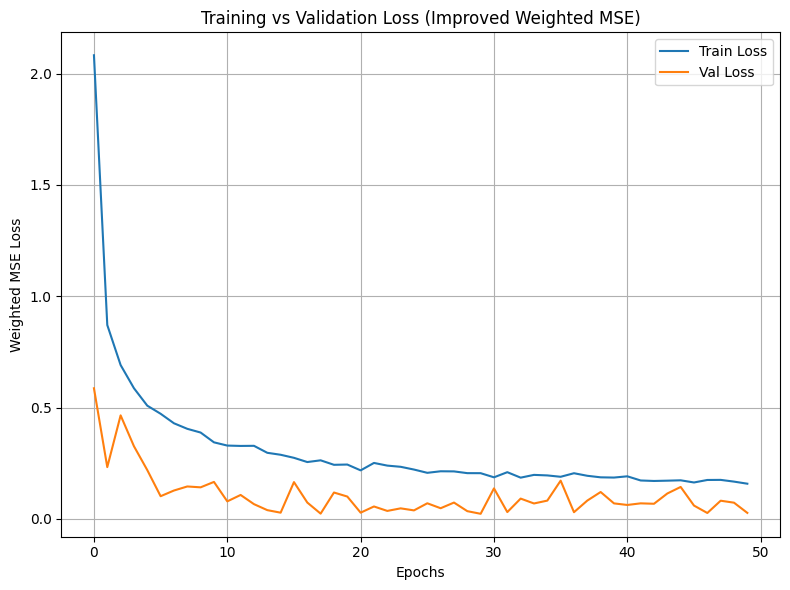

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history_improved.history['loss'], label='Train Loss')
plt.plot(history_improved.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss (Improved Weighted MSE)')
plt.xlabel('Epochs')
plt.ylabel('Weighted MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [40]:
# 🧠 Rebuild the model with best hyperparameters again
model_huber = keras.Sequential()
model_huber.add(keras.layers.Input(shape=(X_train.shape[1],)))

for i in range(best_hps.get('num_layers')):
    model_huber.add(keras.layers.Dense(best_hps.get(f'units_{i}'), activation='relu'))
    model_huber.add(keras.layers.BatchNormalization())
    model_huber.add(keras.layers.Dropout(best_hps.get(f'dropout_{i}')))

model_huber.add(keras.layers.Dense(1))

# ⚙️ Compile with Huber loss
model_huber.compile(
    optimizer=keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate')),
    loss=keras.losses.Huber(delta=1.0),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

# 🛑 Early stopping
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True
)

# 🚀 Train
history_huber = model_huber.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/150
528/528 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2853 - mean_absolute_error: 0.5776 - val_loss: 0.0045 - val_mean_absolute_error: 0.0670
Epoch 2/150
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0602 - mean_absolute_error: 0.2106 - val_loss: 0.0068 - val_mean_absolute_error: 0.0721
Epoch 3/150
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0395 - mean_absolute_error: 0.1634 - val_loss: 0.0041 - val_mean_absolute_error: 0.0515
Epoch 4/150
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0339 - mean_absolute_error: 0.1486 - val_loss: 0.0057 - val_mean_absolute_error: 0.0557
Epoch 5/150
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0286 - mean_absolute_error: 0.1386 - val_loss: 0.0081 - val_mean_absolute_error: 0.0584
Epoch 6/150
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0296 - mean_absolute_error: 0.1359 - val_loss: 0.0167 - val_mean_absolute_error: 0.0890
Epoch 7/150
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0274 - mean_absolute_error: 0.1

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 🔍 Predict on test set
y_pred_huber = model_huber.predict(X_test).flatten()

# 📊 Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred_huber))
mae = mean_absolute_error(y_test, y_pred_huber)
r2 = r2_score(y_test, y_pred_huber)

print("📌 Evaluation (Huber Loss Model):")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")


703/703 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step
📌 Evaluation (Huber Loss Model):
RMSE: 0.0939
MAE: 0.0621
R² Score: 0.9925


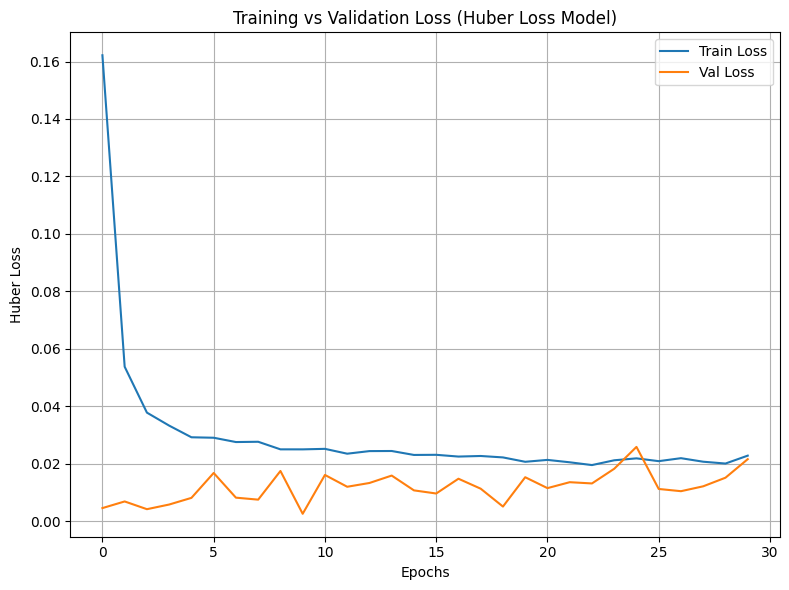

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history_huber.history['loss'], label='Train Loss')
plt.plot(history_huber.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss (Huber Loss Model)')
plt.xlabel('Epochs')
plt.ylabel('Huber Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


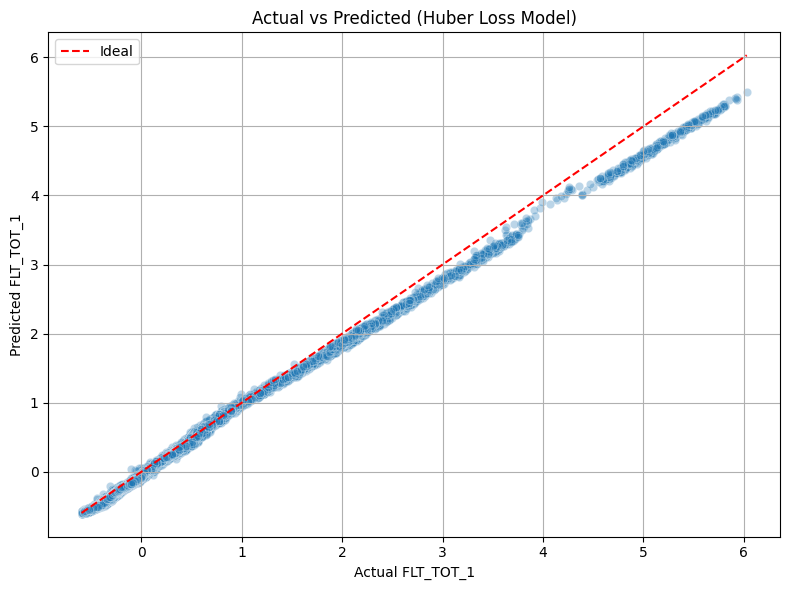

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 📊 Create DataFrame for comparison
results_df_huber = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred_huber
})

# 📈 Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df_huber, x='Actual', y='Predicted', alpha=0.3)
plt.plot([results_df_huber['Actual'].min(), results_df_huber['Actual'].max()],
         [results_df_huber['Actual'].min(), results_df_huber['Actual'].max()],
         color='red', linestyle='--', label='Ideal')
plt.title('Actual vs Predicted (Huber Loss Model)')
plt.xlabel('Actual FLT_TOT_1')
plt.ylabel('Predicted FLT_TOT_1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [44]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

# 🎯 Use Huber loss
def huber_loss():
    return keras.losses.Huber(delta=1.0)

# 🏗️ Model builder with dropout + L2 regularization
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(X_train.shape[1],)))

    for i in range(hp.Int("num_layers", 2, 4)):
        model.add(keras.layers.Dense(
            units=hp.Choice(f'units_{i}', [32, 64, 128]),
            activation='relu',
            kernel_regularizer=keras.regularizers.l2(
                hp.Choice("l2_lambda", [1e-4, 1e-3, 0.0])  # optional L2
            )
        ))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dropout(rate=hp.Choice(f'dropout_{i}', [0.2, 0.25, 0.3])))

    model.add(keras.layers.Dense(1))

    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Choice("learning_rate", [1e-4, 3e-4, 1e-3])
        ),
        loss=huber_loss(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )
    return model

# 🧼 Clear previous tuner state if needed
import shutil
shutil.rmtree('kt_dir', ignore_errors=True)

# 🔍 Initialize tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='kt_dir',
    project_name='dnn_huber_refined'
)

# 🛑 Early stopping with longer patience for smoother convergence
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# 🚀 Run search
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=64,  # ⚠️ smaller batch size for stability
    callbacks=[early_stop],
    verbose=1
)


Trial 10 Complete [00h 01m 11s]
val_loss: 0.008460990153253078

Best val_loss So Far: 0.0003787545720115304
Total elapsed time: 00h 12m 03s


In [45]:
# 🔍 Get best hyperparameters from tuner
best_hps = tuner.get_best_hyperparameters(1)[0]

# 🧠 Rebuild best model manually
model_refined = keras.Sequential()
model_refined.add(keras.layers.Input(shape=(X_train.shape[1],)))

for i in range(best_hps.get('num_layers')):
    model_refined.add(keras.layers.Dense(
        best_hps.get(f'units_{i}'),
        activation='relu',
        kernel_regularizer=keras.regularizers.l2(best_hps.get('l2_lambda'))
    ))
    model_refined.add(keras.layers.BatchNormalization())
    model_refined.add(keras.layers.Dropout(best_hps.get(f'dropout_{i}')))

model_refined.add(keras.layers.Dense(1))

# 🎯 Compile with Huber Loss
model_refined.compile(
    optimizer=keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate')),
    loss=keras.losses.Huber(delta=1.0),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

# 🛑 Early Stopping
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# 🚀 Train with tracking
history_refined = model_refined.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.2097 - mean_absolute_error: 0.4668 - val_loss: 0.0032 - val_mean_absolute_error: 0.0550
Epoch 2/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0442 - mean_absolute_error: 0.1728 - val_loss: 0.0034 - val_mean_absolute_error: 0.0535
Epoch 3/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0375 - mean_absolute_error: 0.1599 - val_loss: 0.0024 - val_mean_absolute_error: 0.0442
Epoch 4/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0341 - mean_absolute_error: 0.1572 - val_loss: 0.0011 - val_mean_absolute_error: 0.0347
Epoch 5/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0287 - mean_absolute_error: 0.1526 - val_loss: 8.8164e-04 - val_mean_absolute_error: 0.0300
Epoch 6/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0272 - mean_absolute_error: 0.1514 - val_loss: 0.0041 - val_mean_absolute_error: 0.0399
Epoch 7/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0257 - mean_a

In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 🔍 Predict on test set
y_pred_refined = model_refined.predict(X_test).flatten()

# 📊 Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred_refined))
mae = mean_absolute_error(y_test, y_pred_refined)
r2 = r2_score(y_test, y_pred_refined)

print("📌 Evaluation (Refined Huber Model):")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")


703/703 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
📌 Evaluation (Refined Huber Model):
RMSE: 0.0454
MAE: 0.0276
R² Score: 0.9983


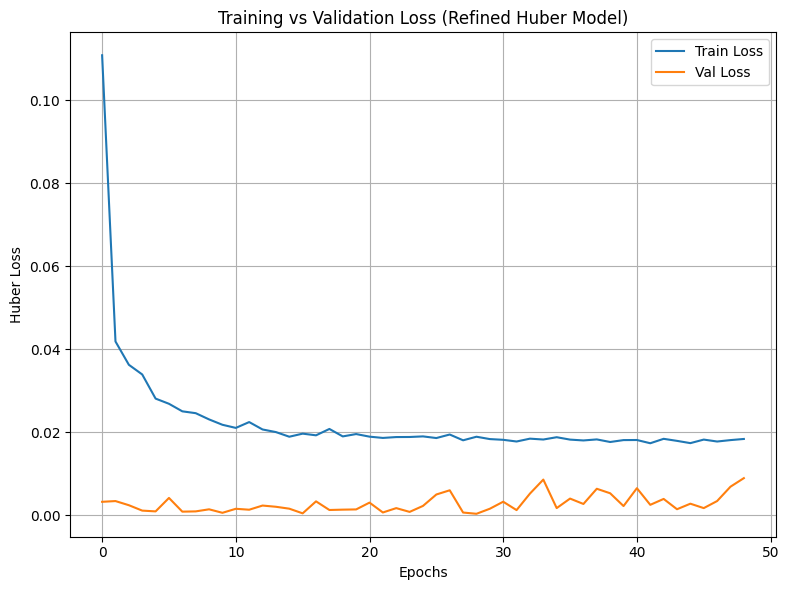

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(history_refined.history['loss'], label='Train Loss')
plt.plot(history_refined.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss (Refined Huber Model)')
plt.xlabel('Epochs')
plt.ylabel('Huber Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


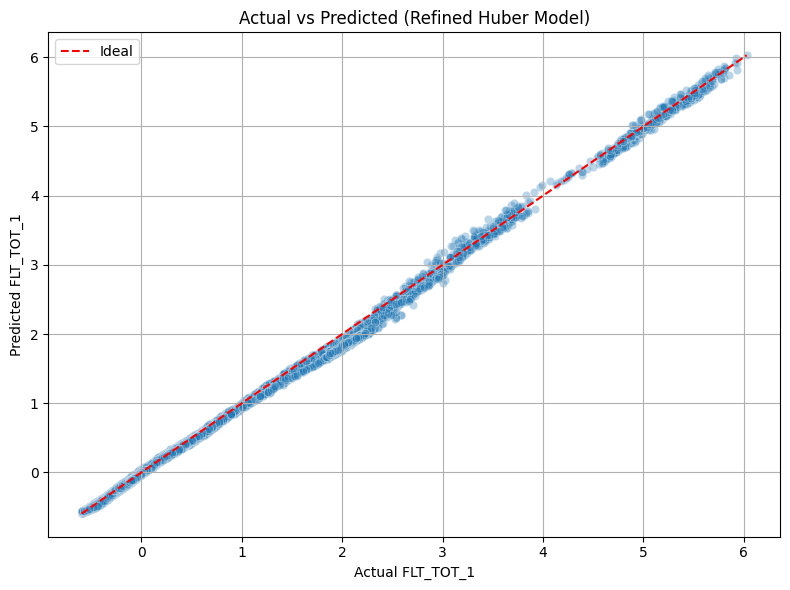

In [48]:
import pandas as pd
import seaborn as sns

results_df_refined = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred_refined
})

plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df_refined, x='Actual', y='Predicted', alpha=0.3)
plt.plot([results_df_refined['Actual'].min(), results_df_refined['Actual'].max()],
         [results_df_refined['Actual'].min(), results_df_refined['Actual'].max()],
         color='red', linestyle='--', label='Ideal')
plt.title('Actual vs Predicted (Refined Huber Model)')
plt.xlabel('Actual FLT_TOT_1')
plt.ylabel('Predicted FLT_TOT_1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [49]:
# 🔁 Denormalize y_test and y_pred
y_test_denorm = y_scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()
y_pred_refined_denorm = y_scaler.inverse_transform(y_pred_refined.reshape(-1, 1)).flatten()


In [50]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse_denorm = np.sqrt(mean_squared_error(y_test_denorm, y_pred_refined_denorm))
mae_denorm = mean_absolute_error(y_test_denorm, y_pred_refined_denorm)
r2_denorm = r2_score(y_test_denorm, y_pred_refined_denorm)

print("📌 Denormalized Evaluation (Refined Huber Model):")
print(f"RMSE: {rmse_denorm:.2f}")
print(f"MAE: {mae_denorm:.2f}")
print(f"R² Score: {r2_denorm:.4f}")


📌 Denormalized Evaluation (Refined Huber Model):
RMSE: 11.04
MAE: 6.72
R² Score: 0.9983


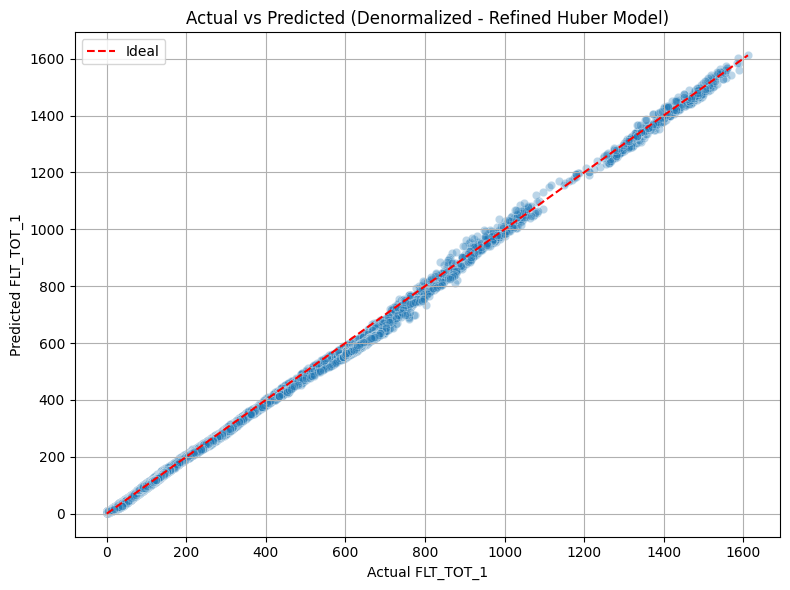

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

results_df_denorm = pd.DataFrame({
    'Actual': y_test_denorm,
    'Predicted': y_pred_refined_denorm
})

plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df_denorm, x='Actual', y='Predicted', alpha=0.3)
plt.plot([results_df_denorm.min().min(), results_df_denorm.max().max()],
         [results_df_denorm.min().min(), results_df_denorm.max().max()],
         color='red', linestyle='--', label='Ideal')
plt.title('Actual vs Predicted (Denormalized - Refined Huber Model)')
plt.xlabel('Actual FLT_TOT_1')
plt.ylabel('Predicted FLT_TOT_1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [52]:
# Save the refined model
model_refined.save("DFNN_model.keras")

print("✅ Final DFNN model saved as: DFNN_model.keras")


✅ Final DFNN model saved as: DFNN_model.keras
